### CODE SUMMARY


READ ALL DATA                                                                                                                   

CONVERT RA, DEC TO SUITABLE DATA_VECTORS FROM THE DATA                                                                          

DIVIDE ICECUBE DATA TO 441 LENGTH VECTORS TO MATCH MSPSRDATA VECTOR SIZE                                                        

CIRCULARLY ITERATE THROUGH ICECUBE VECTORS TO GET SPACE ANGLES AT 441 x 441 ANGLES PER ITERATION FOR 2373 ITERATIONS            

PLOT THE RESULTS IN A GRAPH                                                                                                     


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#import astropy.coordinates as asc
from dask import delayed
#from dask import array as da

In [2]:
path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
 "IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]

In [3]:
file = filenames[0]
f = open(os.path.join(path, file), 'r')

lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []

In [4]:
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()

In [5]:
icdata = pd.DataFrame(content, columns=column)

In [6]:

f = open("10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()

for line in lines[:]:
    content.append(line.split())

#the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]

In [7]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return a

In [8]:
icra = [float(i) for i in icdata['RA[deg]']]
icdec = [float(i) for i in icdata['Dec[deg]']]
icra.extend([0]*(243))
icdec.extend([0]*(243))
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icdata = []
mspdata = []

lg = int(len(icra)/len(msra))
p = len(msra)
res = []
for k in range(lg):#2573
        lo = []
        la = []
        for j in range(k,p + k):#441
                lo = [icra[(j + i + p)%p] for i in range(0,p)]
                la = [icdec[(j + i + p)%p] for i in range(0,p)]
                
                res.append((hvovec(lo, la, msra, msdec)))
lo = []
la = []

In [9]:
lg = int(len(icra)/len(msra))
p = len(msra)
res = []
r= []
for k in range(lg):
    lo =[]
    la = []
    for j in range(k,p + k):#441
                lo = [msra[(i + p)%p] for i in range(0,p)]
                la = [msdec[(i + p)%p] for i in range(0,p)]
                r.append(delayed(hvovec(icra[k :p+k], icdec[k:p+k], lo, la)))

In [10]:
icra.clear()
icdec.clear()
msra.clear()
msdec.clear()
r = [r[i].compute() for i in range(len(r))]


In [11]:
r = np.ravel(r)

In [15]:
len(r)

500399613

The data is binned between 0 and 7.35 degrees into 6 equispaced cos (theta) bins

(The bin closest to 0 corresponds to 3 degrees)

The average of the last 5 bins will constitute the background.

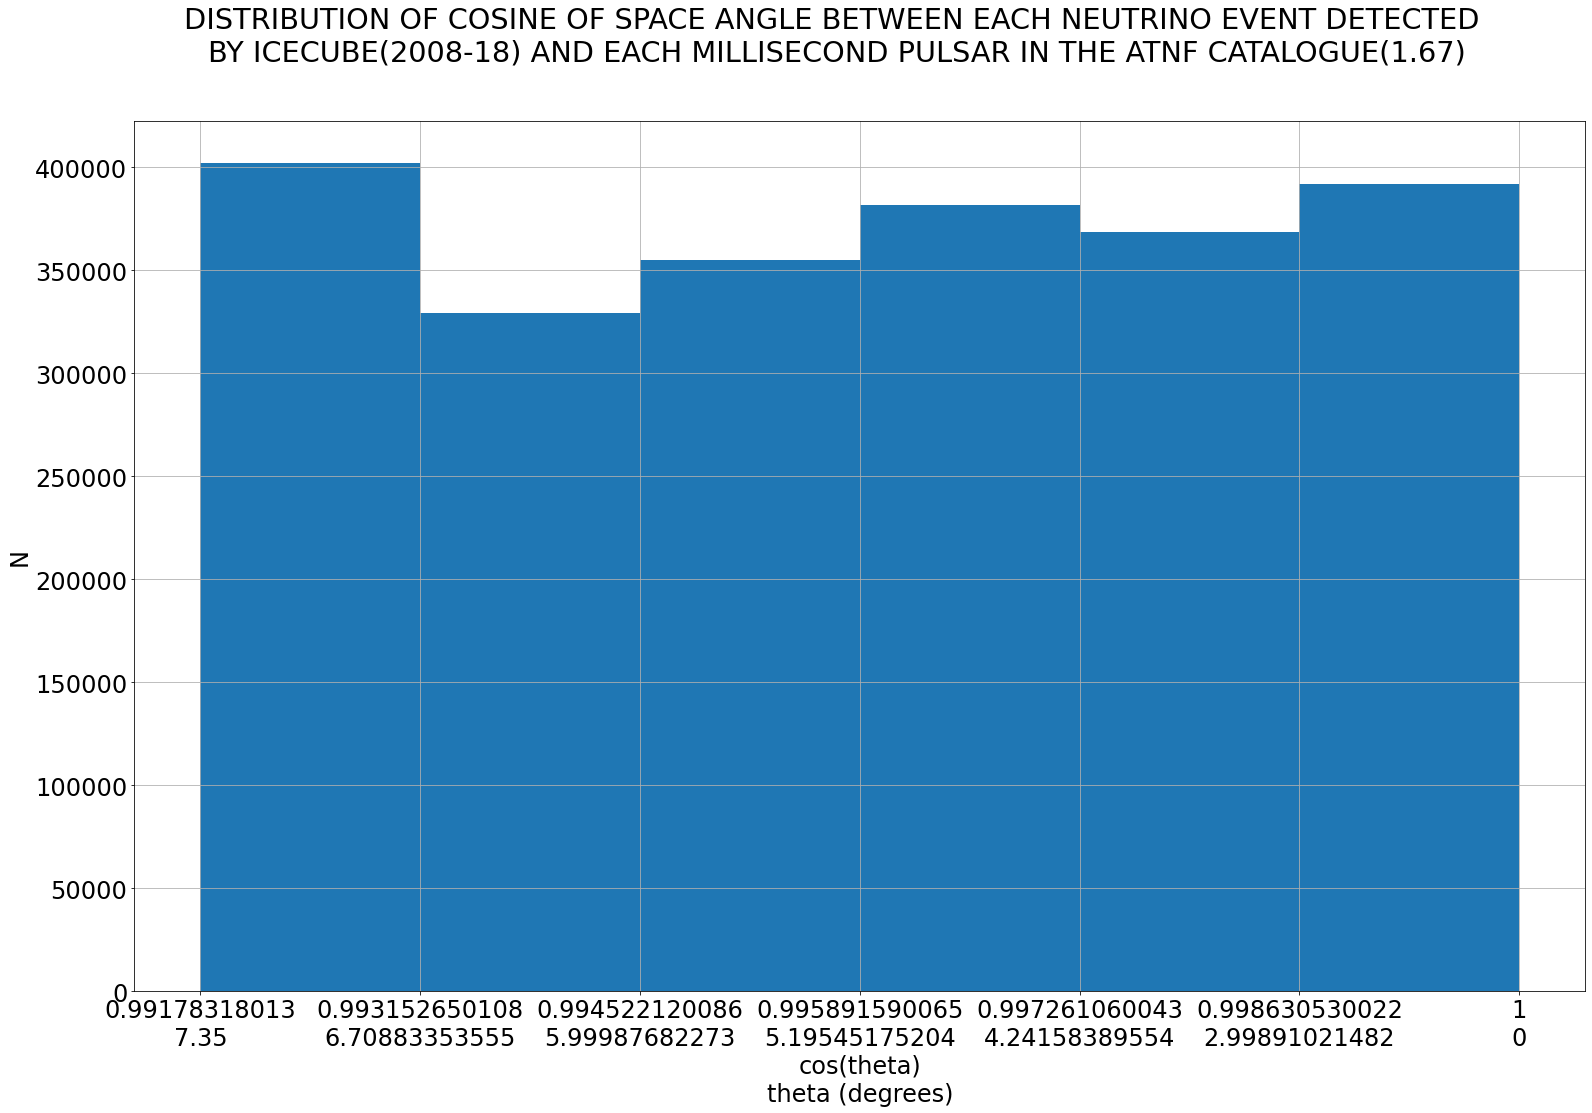

In [19]:
plt.figure(figsize=(26,16))
plt.rcParams.update({'font.size': 24})

nbins = np.linspace(np.cos(np.radians(7.35)), np.cos(0),  7)
nb = ['0.99178318013\n7.35', '0.993152650108\n6.70883353555', '0.994522120086\n5.99987682273', '0.995891590065\n5.19545175204', '0.997261060043\n4.24158389554', '0.998630530022\n2.99891021482', '1\n0']
plt.hist(r, bins= nbins)
plt.xlabel("cos(theta)\ntheta (degrees)")
plt.ylabel("N")
plt.xticks(nbins, nb)
#plt.ylim([0, 8 * 10**6])
plt.suptitle('DISTRIBUTION OF COSINE OF SPACE ANGLE BETWEEN EACH NEUTRINO EVENT DETECTED \n'
                                +'BY ICECUBE(2008-18) AND EACH MILLISECOND PULSAR IN THE ATNF CATALOGUE(1.67)')
plt.grid(True, which="both")
plt.show()